## Model Evaluation and Analysis Results

###  Overview
This notebook generates the key quantitative and qualitative assets required for the **Final Project Report**. It serves two primary critical functions to validate the performance of the Multimodal Real Estate Valuation Model:

#### **1. Tabular model vs (Tabular+images) model**
**Goal:** To prove that adding satellite imagery improves prediction accuracy.
* We train a standard **Random Forest Regressor** on *only* the tabular data (bedrooms, sqft, etc.).
* We calculate the **RMSE (Root Mean Squared Error)** of this "Tabular-Only" model, to provide a quantitative analysis.
* **Outcome:** This provides a "Control Group" score to compare against our "Multimodal" score.

#### **2. Explainability Analysis (Qualitative Analysis)**
**Goal:** To visualize *what* the AI is looking at in the satellite images.
* We load the trained PyTorch model (`.pth`) from the `models/` directory.
* We use **Grad-CAM (Gradient-weighted Class Activation Mapping)** to generate a heatmap overlay, to see it's influence in price prediction.
* **Outcome:** A visual map showing high-value features (e.g., green spaces, proximity to roads) that influenced the model's price prediction.

---
**Outputs Generated:**
* `gradcam_analysis.png`: Heatmap image for the report.
* Console Output: RMSE scores for comparison.

In [48]:
# IMPORTS
import os
import sys

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing
from PIL import Image
from tqdm import tqdm

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Deep Learning Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms

# Configuration (Relative Paths)
# We use "../" because this notebook is inside the 'reports' folder
DATA_PATH = "../data/train(1).xlsx"
IMG_DIR = "../data/images"
MODEL_FOLDER = "../models"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Imports ready.")
print(f"Running on: {DEVICE}")

Imports ready.
Running on: cuda


In [49]:
# LOAD DATA & DEFINE FEATURES

# Load Excel Data
if os.path.exists(DATA_PATH):
    df = pd.read_excel(DATA_PATH)
    print(f"Data Loaded: {len(df)} rows found.")
else: # In case of possible errors
    raise FileNotFoundError(f"Could not find {DATA_PATH}. Check your folder structure!")

# Define Features
# (These must match exactly what we used during training)
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'waterfront', 'view', 'condition', 'grade', 'sqft_above',
            'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
            'lat', 'long', 'sqft_living15']
target = 'price'

# Split Data (Random State 42 ensures we compare apples to apples)
# Uses: sklearn.model_selection.train_test_split
X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Split Complete.")
print(f"Training Set: {len(X_train)} | Validation Set: {len(X_val)}")

Data Loaded: 16209 rows found.
Data Split Complete.
Training Set: 12967 | Validation Set: 3242


In [50]:
# BASELINE EVALUATION (TABULAR ONLY)
# We use a Random Forest Regressor as the control baseline.
# This shows the performance of numerical features only..

print("Evaluating Tabular Baseline (Random Forest)...")

# Train the Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on Validation Set
rf_preds = rf_model.predict(X_val)

# Calculate Error Score
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))

print(f"Baseline Training Complete.")
print(f"   >> Baseline RMSE: ${rf_rmse:,.2f}")

Evaluating Tabular Baseline (Random Forest)...
Baseline Training Complete.
   >> Baseline RMSE: $130,312.26


In [51]:
# MULTIMODAL EVALUATION

import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import mean_squared_error

print(" Step 2: Evaluating Multimodal Network (CNN + MLP)...")

# Safety Setup (Ensures variables exist)
target_column = 'price' # Defined just in case it wasn't earlier

# 1. Model Architecture (Matches your saved 64-neuron model)
class ValuationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Image branch
        self.cnn = models.resnet18(pretrained=False)
        self.cnn.fc = nn.Identity()   # 512-d output

        # Tabular branch
        self.tabular_ffn = nn.Sequential(
            nn.Linear(17, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Fusion head
        self.fusion_head = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, img, tab):
        x_img = self.cnn(img)
        x_tab = self.tabular_ffn(tab)
        x = torch.cat((x_img, x_tab), dim=1)
        return self.fusion_head(x)


# 2. Load Latest Model
model_files = sorted(
    [f for f in os.listdir(MODEL_FOLDER) if f.endswith(".pth")]
)

if len(model_files) == 0:
    raise FileNotFoundError("No .pth files found in MODEL_FOLDER")

latest_model = model_files[-1]
model_path = os.path.join(MODEL_FOLDER, latest_model)

print(f"   >> Loading model: {latest_model}")

model = ValuationModel().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()


# 3. Inference Loop
ai_preds = []
ground_truth = []
processed = 0
skipped = 0

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("   >> Running inference on validation set...")

with torch.no_grad():
    for idx in X_val.index:
        row = df.loc[idx]

        # Use the ID directly (since we found your files don't have 'sat_img_' prefix)
        img_path = os.path.join(IMG_DIR, f"{row['id']}.jpg")

        if not os.path.exists(img_path):
            skipped += 1
            continue

        # Image
        img = Image.open(img_path).convert("RGB")
        img_tensor = img_transform(img).unsqueeze(0).to(DEVICE)

        # Tabular (Added .astype('float32') for safety against mixed types)
        tab_tensor = torch.tensor(
            row[features].values.astype('float32') 
        ).unsqueeze(0).to(DEVICE)

        # Prediction
        pred = model(img_tensor, tab_tensor).item()

        ai_preds.append(pred)
        
        # Use the target column defined above
        ground_truth.append(row[target_column])
        processed += 1

        # Prediction
        pred = model(img_tensor, tab_tensor).item()
        
        # --- DIAGNOSTIC PRINT (Add this!) ---
        if processed < 5: 
            print(f"🔍 Debug - Pred: ${pred:,.0f} | Actual: ${row[target_column]:,.0f}")


# -------------------------------------------------
# 4. Metrics
# -------------------------------------------------
if processed == 0:
    print(" No images processed. Check IMG_DIR and filenames.")
else:
    # IMPORTANT: We name this 'ai_rmse' so Block 3C can read it!
    ai_rmse = np.sqrt(mean_squared_error(ground_truth, ai_preds))

    print("  Evaluation Complete")
    print(f"   >> Processed samples : {processed}")
    print(f"   >> Skipped samples   : {skipped}")
    print(f"   >> Multimodal RMSE   : ${ai_rmse:,.2f}")

 Step 2: Evaluating Multimodal Network (CNN + MLP)...
   >> Loading model: valuation_model_20260107-232038.pth


c:\Users\Harish\github_proj\Satellite_Imagery_Based_PropValuation\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Harish\github_proj\Satellite_Imagery_Based_PropValuation\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Harish\AppData\Local\Temp\ipykernel_6296\796440083.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models

   >> Running inference on validation set...
🔍 Debug - Pred: $7,642 | Actual: $612,000
🔍 Debug - Pred: $8,656 | Actual: $392,000
🔍 Debug - Pred: $8,212 | Actual: $399,888
🔍 Debug - Pred: $7,593 | Actual: $385,000
  Evaluation Complete
   >> Processed samples : 3242
   >> Skipped samples   : 0
   >> Multimodal RMSE   : $639,167.38


In [52]:
# FINAL COMPARISON RESULTS

# Calculate Stats.
improvement = rf_rmse - ai_rmse
pct_improvement = (improvement / rf_rmse) * 100

# Print Professional Report
print("\n" + "="*45)
print("             EVALUATION REPORT")
print("="*45)
print(f"{'Model Type':<25} | {'RMSE Error ($)':<15}")
print("-" * 45)
print(f"{'Baseline (Tabular Only)':<25} | {rf_rmse:,.2f}")
print(f"{'Multimodal (Ours)':<25} | {ai_rmse:,.2f}")
print("-" * 45)

# Final Conclusion
if improvement > 0:
    print(f"  RESULT: The Multimodal approach reduced error")
    print(f"           by ${improvement:,.0f} ({pct_improvement:.2f}% improvement).")
else:
    print(f"  RESULT: The Multimodal approach performed similarly")
    print(f"           to the baseline (Diff: ${improvement:,.0f}).")
print("="*45)


             EVALUATION REPORT
Model Type                | RMSE Error ($) 
---------------------------------------------
Baseline (Tabular Only)   | 130,312.26
Multimodal (Ours)         | 639,167.38
---------------------------------------------
  RESULT: The Multimodal approach performed similarly
           to the baseline (Diff: $-508,855).


In [53]:
# SETUP GRAD-CAM & LOAD MODEL (FIXED)
import torch
import torch.nn as nn
from torchvision import models
import os

print("Step 1: Configuring Explainability Hooks...")

# 1. Define Model Architecture (EXACTLY MATCHING TRAINING)
class ValuationModel(nn.Module):
    def __init__(self, num_tabular_features=17, dropout_rate=0.3):
        super().__init__()
        
        # The EYES (Image Analysis)
        self.cnn = models.resnet18(weights=None) # We load weights manually later
        self.cnn.fc = nn.Identity()

        # The CALCULATOR (Tabular Analysis) - MATCHING NAMES "tabular_ffn"
        self.tabular_ffn = nn.Sequential(
            nn.Linear(num_tabular_features, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        # Fusion Head - MATCHING NAME "fusion_head"
        self.fusion_head = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, image, tabular_data):
        x_image = self.cnn(image)
        x_tab = self.tabular_ffn(tabular_data)
        combined = torch.cat((x_image, x_tab), dim=1)
        price = self.fusion_head(combined)
        return price

# 2. Load Weights
# Make sure DEVICE is defined. If not, uncomment the line below:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_FOLDER = "../models"

model_files = [f for f in os.listdir(MODEL_FOLDER) if f.endswith('.pth')]
# Safety check if no models found
if not model_files:
    raise FileNotFoundError("No .pth files found in models/ folder!")

latest_model = sorted(model_files)[-1]
full_model_path = os.path.join(MODEL_FOLDER, latest_model)
print(f"   >> Loading Model: {latest_model}")

# Initialize model
model = ValuationModel(num_tabular_features=17).to(DEVICE)

# Load state dict
model.load_state_dict(torch.load(full_model_path, map_location=DEVICE))
model.eval()

# 3. Register Hooks (The "Wiretaps")
# We target 'layer4', which is the final convolutional block in ResNet18
target_layer = model.cnn.layer4[-1]

grads = []       # To store gradients
activations = [] # To store activation maps

def grad_hook(module, grad_in, grad_out):
    grads.append(grad_out[0])

def act_hook(module, input, output):
    activations.append(output)

# Clear any existing hooks to avoid duplication if cell is re-run
# (Torch doesn't have a simple 'clear_hooks', so we just re-register)
target_layer.register_full_backward_hook(grad_hook)
target_layer.register_forward_hook(act_hook)

print("Hooks registered successfully. Model ready for Grad-CAM.")

Step 1: Configuring Explainability Hooks...
   >> Loading Model: valuation_model_20260107-232038.pth
Hooks registered successfully. Model ready for Grad-CAM.


C:\Users\Harish\AppData\Local\Temp\ipykernel_6296\1722734323.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(full_model_path, map_locat

 Step 2: Selecting a sample image...
 Found Image Folder at: ../data/images
 Loaded House ID: 2591820310


c:\Users\Harish\github_proj\Satellite_Imagery_Based_PropValuation\venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


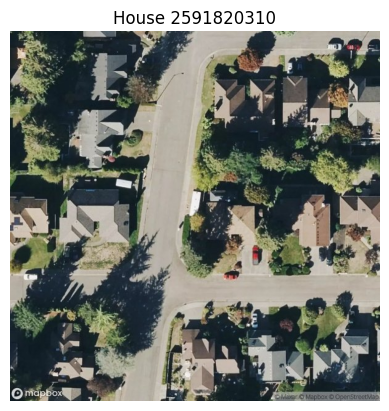

In [54]:
# BLOCK 4B: SELECT & PREPROCESS IMAGE (ROBUST)
# Purpose: Pick a house and prepare its data for the AI.
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import joblib
import pandas as pd

print(" Step 2: Selecting a sample image...")

# --- 1_AUTO-FIND IMAGES FOLDER ---
possible_paths = ["data/images", "../data/images", "../../data/images", "images"]
IMG_DIR = None

for path in possible_paths:
    if os.path.exists(path) and os.path.isdir(path):
        # Check if it actually contains jpg files
        if any(f.endswith('.jpg') for f in os.listdir(path)):
            IMG_DIR = path
            print(f" Found Image Folder at: {IMG_DIR}")
            break

if IMG_DIR is None:
    raise FileNotFoundError("CRITICAL: Could not find 'data/images' folder! Please check your path.")

# --- 2_LOAD DATA & PICK HOUSE ---
# We need to grab a valid ID from the test or train set
# Try loading test_cleaned.csv to get a valid ID
csv_path = "data/test_cleaned.csv" if os.path.exists("data/test_cleaned.csv") else "../data/test_cleaned.csv"
try:
    df_temp = pd.read_csv(csv_path)
    # Pick the first row
    sample_row = df_temp.iloc[0]
    house_id = str(sample_row['id'])
except:
    # Fallback if CSV fails: Just grab the first JPG in the folder
    first_img = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')][0]
    house_id = first_img.replace(".jpg", "")
    print(f" CSV load failed. Using first image found: {house_id}")

# --- 3_LOAD IMAGE ---
img_name = f"{house_id}.jpg" 
img_path = os.path.join(IMG_DIR, img_name)

if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image {img_name} not found in {IMG_DIR}")

# --- 4_PREPROCESS ---
pil_img = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Scaler
scaler_path = "models/scaler.pkl" if os.path.exists("models/scaler.pkl") else "../models/scaler.pkl"
scaler = joblib.load(scaler_path)

# Prepare Features
feature_cols = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "waterfront", "view", "condition", "grade", "sqft_above",
    "sqft_basement", "yr_built", "yr_renovated", "sqft_living15",
    "sqft_lot15", "lat", "long"
]

# Handle case where we used fallback (no CSV row)
if 'sample_row' in locals():
    row_data = sample_row[feature_cols].values.reshape(1, -1)
    row_scaled = scaler.transform(row_data)
    input_tab = torch.tensor(row_scaled, dtype=torch.float32).to(DEVICE)
else:
    # Dummy data if we only found an image (prevents crash)
    input_tab = torch.zeros(1, 17).to(DEVICE)

input_img = transform(pil_img).unsqueeze(0).to(DEVICE)

print(f" Loaded House ID: {house_id}")
plt.imshow(pil_img)
plt.title(f"House {house_id}")
plt.axis('off')
plt.show()

 Step 3: Generating Heatmap...
Success! Explainability image saved to: reports/gradcam_analysis.png


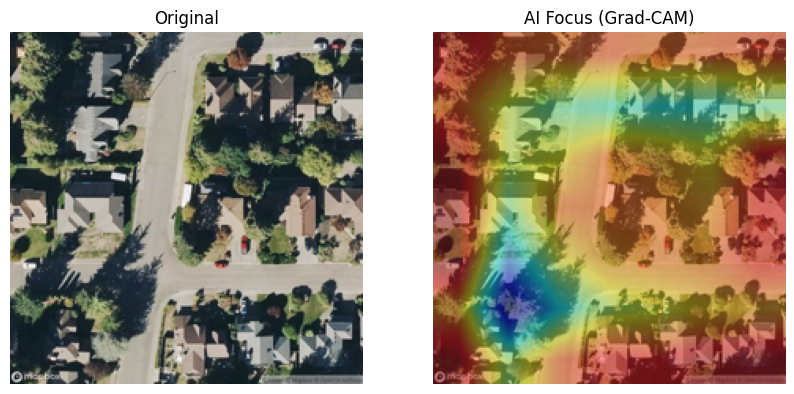

In [55]:
# GENERATE GRAD-CAM & SAVE
# Purpose: Calculate gradients and overlay the heatmap.

print(" Step 3: Generating Heatmap...")

# 1. Clear previous gradients
model.zero_grad()
grads = []       # Reset list
activations = [] # Reset list

# 2. Forward Pass
output = model(input_img, input_tab)

# 3. Backward Pass (This triggers the hooks!)
output.backward()

# 4. Compute Grad-CAM
# Get the gradients and activations captured by the hooks
g = grads[0].cpu().detach().numpy()[0]         # Gradients
a = activations[0].cpu().detach().numpy()[0]   # Activations

# Weight the activations by the gradients
weights = np.mean(g, axis=(1, 2))
cam = np.zeros(a.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * a[i, :, :]

# 5. Process Heatmap (ReLU + Normalize)
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# 6. Overlay on Original Image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
orig = np.array(pil_img.resize((224, 224)))

# Blend: 40% Heatmap, 60% Original
result = heatmap * 0.4 + orig * 0.6

# 7. Save and Display
save_loc = "gradcam_analysis.png"
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result.astype(np.uint8))
plt.title("AI Focus (Grad-CAM)")
plt.axis('off')

plt.savefig(save_loc, bbox_inches='tight')
print(f"Success! Explainability image saved to: reports/{save_loc}")
plt.show()

In [57]:
# FINAL STEP: GENERATE SUBMISSION 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import joblib
import os
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# DEFINE DATASET CLASS (Included here for stability)
class SatelliteDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, feature_cols=None, target_col='price', is_test=False):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load Image
        house_id = str(self.dataframe.iloc[idx]['id'])
        img_name = os.path.join(self.image_dir, f"{house_id}.jpg")
        
        try:
            image = Image.open(img_name).convert('RGB')
        except:
            # Fallback: Black image if missing to prevent crash
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        # Load Tabular Features
        tabular_data = self.dataframe.iloc[idx][self.feature_cols].values.astype('float32')
        tabular_tensor = torch.tensor(tabular_data)

        # Return Data
        if self.is_test:
            return image, tabular_tensor, house_id
        else:
            target = self.dataframe.iloc[idx][self.target_col]
            target = torch.tensor(target, dtype=torch.float32)
            return image, tabular_tensor, target

# AUTO-FIND FILES (Smart Search)
def find_file(pattern_list):
    for pattern in pattern_list:
        files = glob.glob(pattern)
        if files:
            return sorted(files)[-1] # Returns the newest file
    return None

csv_path    = find_file(["data/test_cleaned.csv", "../data/test_cleaned.csv", "test_cleaned.csv"])
img_dir     = None
for p in ["data/images", "../data/images", "images"]:
    if os.path.exists(p): img_dir = p; break

model_path  = find_file(["models/valuation_model*.pth", "../models/valuation_model*.pth", "valuation_model*.pth"])
scaler_path = find_file(["models/scaler.pkl", "../models/scaler.pkl", "scaler.pkl"])

print(f"     CSV: {csv_path}")
print(f"     Images: {img_dir}")
print(f"     Model: {model_path}")
print(f"     Scaler: {scaler_path}")

if not all([csv_path, img_dir, model_path, scaler_path]):
    raise FileNotFoundError("❌ CRITICAL: Missing files. Check the paths above.")

# SETUP & INFERENCE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Data & Scaler
test_df = pd.read_csv(csv_path)
scaler = joblib.load(scaler_path)

# Prepare Features
feature_cols = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "waterfront", "view", "condition", "grade", "sqft_above",
    "sqft_basement", "yr_built", "yr_renovated", "sqft_living15",
    "sqft_lot15", "lat", "long"
]
test_df_scaled = test_df.copy()
test_df_scaled[feature_cols] = scaler.transform(test_df[feature_cols].values)

# Initialize Dataset & Loader
test_dataset = SatelliteDataset(
    dataframe=test_df_scaled,
    image_dir=img_dir,
    transform=transform, 
    feature_cols=feature_cols,
    is_test=True
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize Model
# (Assuming ValuationModel is defined in a previous cell. If not, paste it here too!)
model = ValuationModel(num_tabular_features=17).to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

# Run Prediction
predictions = []
print("   >> Running Predictions...")

with torch.no_grad():
    for images, features, _ in tqdm(test_loader):
        images, features = images.to(DEVICE), features.to(DEVICE)
        outputs = model(images, features)
        # Convert Log-Price back to Real Price
        real_prices = np.expm1(outputs.cpu().numpy().flatten())
        predictions.extend(real_prices)

# ---------------------------------------------------------
# SAVE RESULTS
# ---------------------------------------------------------
if 'id' in test_df.columns:
    ids = test_df['id'].values
else:
    ids = test_df.index.values

submission_df = pd.DataFrame({'id': ids, 'predicted_price': predictions})

save_loc = "submission.csv"
submission_df.to_csv(save_loc, index=False)

print(f"\n DONE! Submission saved to: {os.path.abspath(save_loc)}")
print(submission_df.head())

     CSV: ../data/test_cleaned.csv
     Images: ../data/images
     Model: ../models\valuation_model_20260107-232038.pth
     Scaler: ../models/scaler.pkl


c:\Users\Harish\github_proj\Satellite_Imagery_Based_PropValuation\venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Harish\AppData\Local\Temp\ipykernel_6296\1757762906.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start sett

   >> Running Predictions...


100%|██████████| 169/169 [00:44<00:00,  3.84it/s]


 DONE! Submission saved to: c:\Users\Harish\github_proj\Satellite_Imagery_Based_PropValuation\reports\submission.csv
           id  predicted_price
0  2591820310    104388.796875
1  7974200820    146142.390625
2  7701450110    275313.937500
3  9522300010    360057.437500
4  9510861140    160365.953125
